In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [3]:
# Set up visualization style
sns.set(style="whitegrid")


# 1. Load the data
df = pd.read_csv('auto-mpg.csv', na_values='?')

In [5]:
# 2. Initial Data Exploration
print("=== Initial Data Overview ===")

print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)


=== Initial Data Overview ===
Shape: (398, 9)

First 5 rows:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  

Data types:
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car nam

In [6]:
print("\nMissing values:")
print(df.isna().sum())


Missing values:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [7]:
# 3. Data Cleaning
print("\n=== Data Cleaning ===")
# Convert horsepower to numeric (handling missing values represented by '?')
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')


# Impute missing values in horsepower with median
horsepower_median = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(horsepower_median)
print(f"\nImputed {df['horsepower'].isna().sum()} missing values in horsepower with median {horsepower_median}")


=== Data Cleaning ===

Imputed 0 missing values in horsepower with median 93.5


In [8]:
# 4. Feature Engineering
print("\n=== Feature Engineering ===")
# Extract manufacturer from car name
df['manufacturer'] = df['car name'].str.split().str[0]

# Fix some manufacturer names
df['manufacturer'] = df['manufacturer'].replace({
    'chevroelt': 'chevrolet',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'maxda': 'mazda',
    'mercedes': 'mercedes-benz'
})


=== Feature Engineering ===


In [9]:
# 5. Convert categorical variables
print("\nConverting categorical variables...")
df['origin'] = df['origin'].astype('category').cat.rename_categories({
    1: 'USA', 
    2: 'Europe', 
    3: 'Asia'
})
df['cylinders'] = df['cylinders'].astype('category')


Converting categorical variables...


In [10]:
# 6. Drop car name column
df = df.drop('car name', axis=1)


=== Univariate Analysis ===


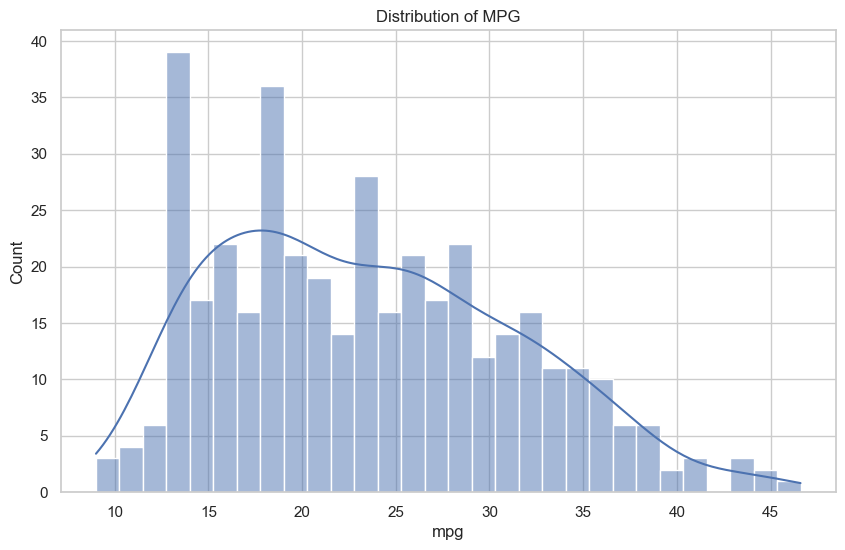

In [16]:
# 7. EDA - Univariate Analysis
print("\n=== Univariate Analysis ===")
# Target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['mpg'], kde=True, bins=30)
plt.title('Distribution of MPG')
plt.show()

In [17]:
# Numerical features summary
print("\nNumerical features summary:")
print(df.describe())


Numerical features summary:
              mpg  displacement  horsepower       weight  acceleration  \
count  398.000000    398.000000  398.000000   398.000000    398.000000   
mean    23.514573    193.425879  104.304020  2970.424623     15.568090   
std      7.815984    104.269838   38.222625   846.841774      2.757689   
min      9.000000     68.000000   46.000000  1613.000000      8.000000   
25%     17.500000    104.250000   76.000000  2223.750000     13.825000   
50%     23.000000    148.500000   93.500000  2803.500000     15.500000   
75%     29.000000    262.000000  125.000000  3608.000000     17.175000   
max     46.600000    455.000000  230.000000  5140.000000     24.800000   

       model year  
count  398.000000  
mean    76.010050  
std      3.697627  
min     70.000000  
25%     73.000000  
50%     76.000000  
75%     79.000000  
max     82.000000  


In [18]:
# Categorical features analysis
print("\nCategorical features analysis:")
print("\nCylinders value counts:")
print(df['cylinders'].value_counts())


Categorical features analysis:

Cylinders value counts:
cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64


In [19]:
print("\nOrigin value counts:")
print(df['origin'].value_counts())


Origin value counts:
origin
USA       249
Asia       79
Europe     70
Name: count, dtype: int64



=== Bivariate Analysis ===


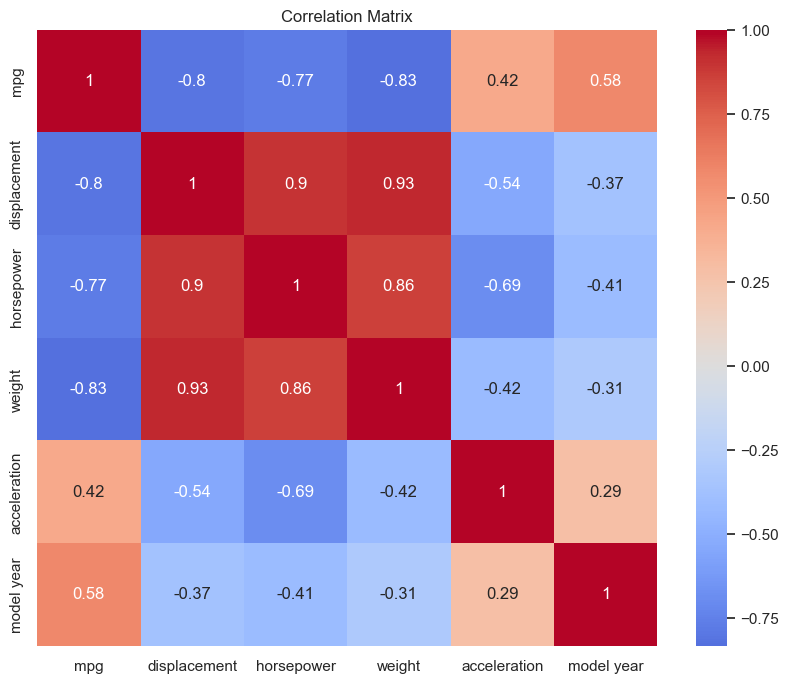

In [20]:
# 8. EDA - Bivariate Analysis
print("\n=== Bivariate Analysis ===")
# Correlation matrix
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

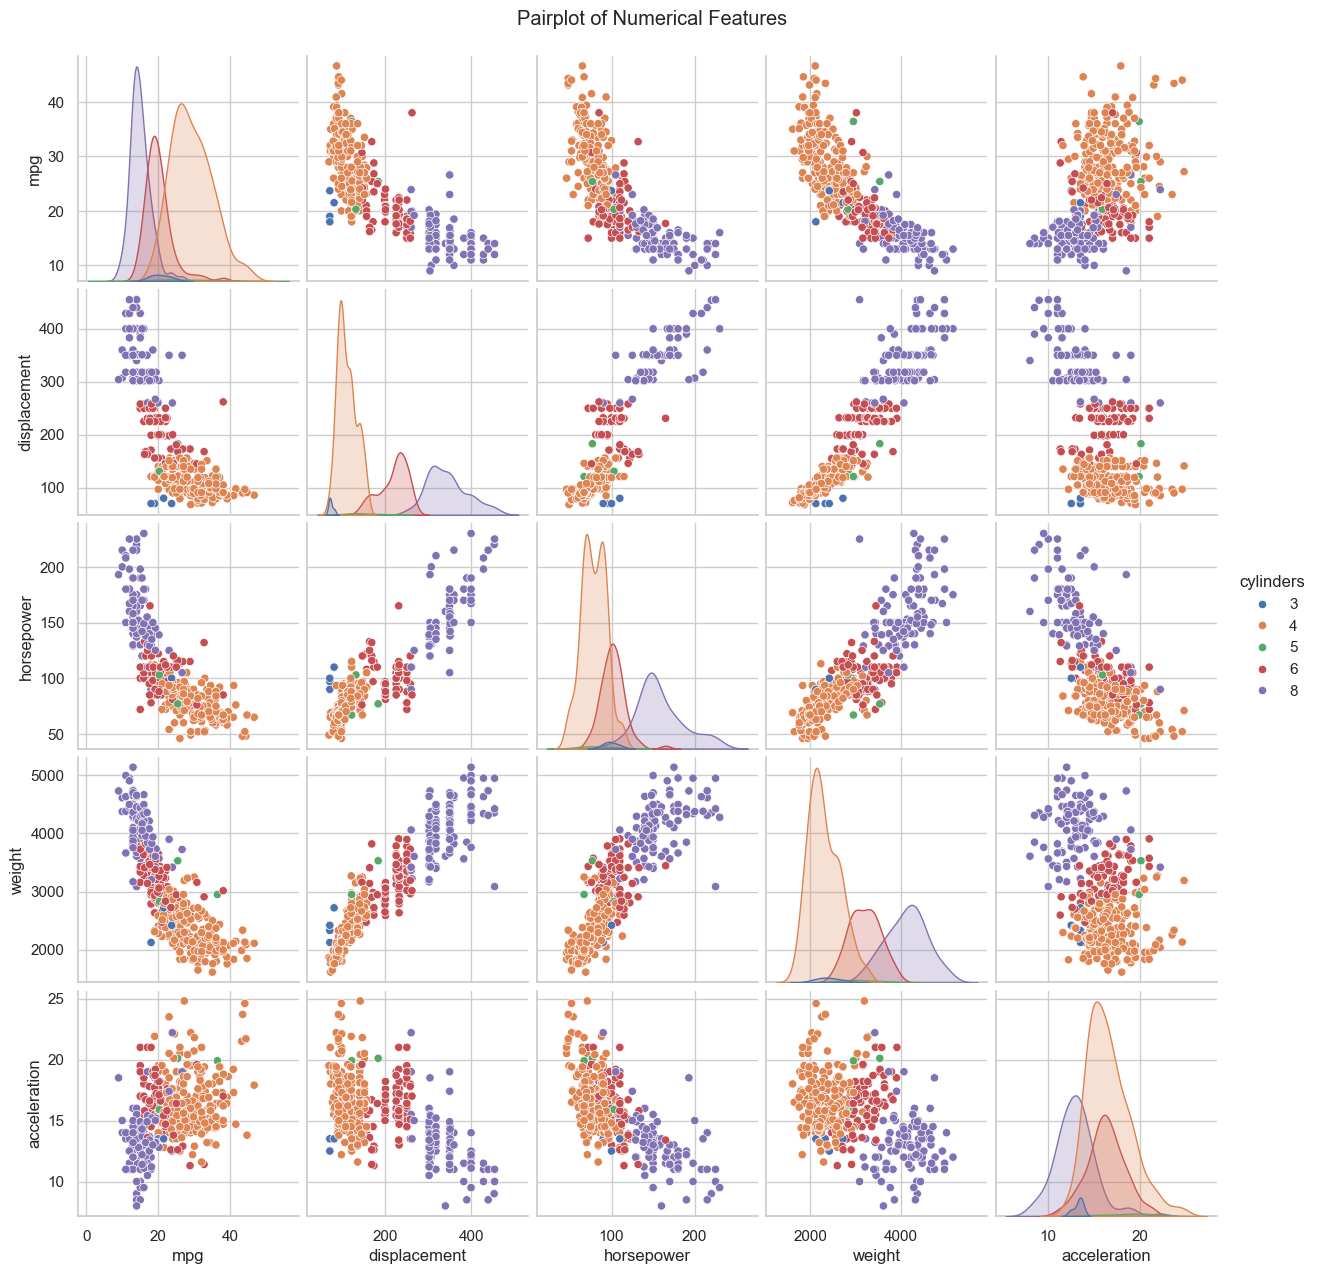

In [21]:
# Pairplot for key numerical features
sns.pairplot(df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']], 
             hue='cylinders', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

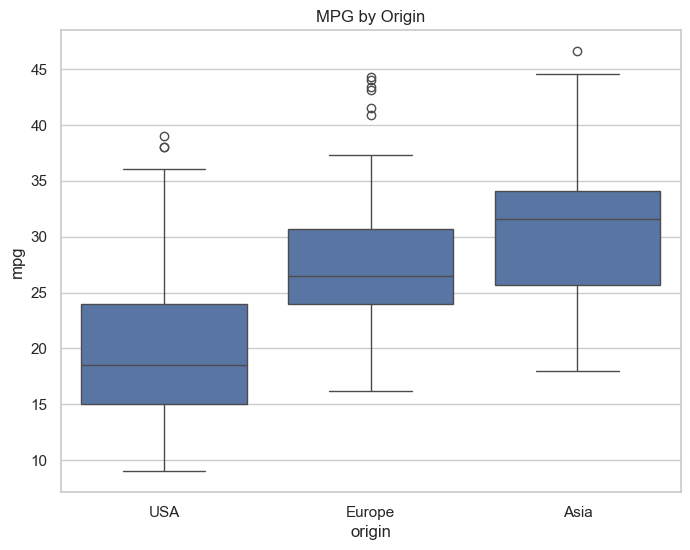

In [22]:
# MPG by origin
plt.figure(figsize=(8, 6))
sns.boxplot(x='origin', y='mpg', data=df)
plt.title('MPG by Origin')
plt.show()

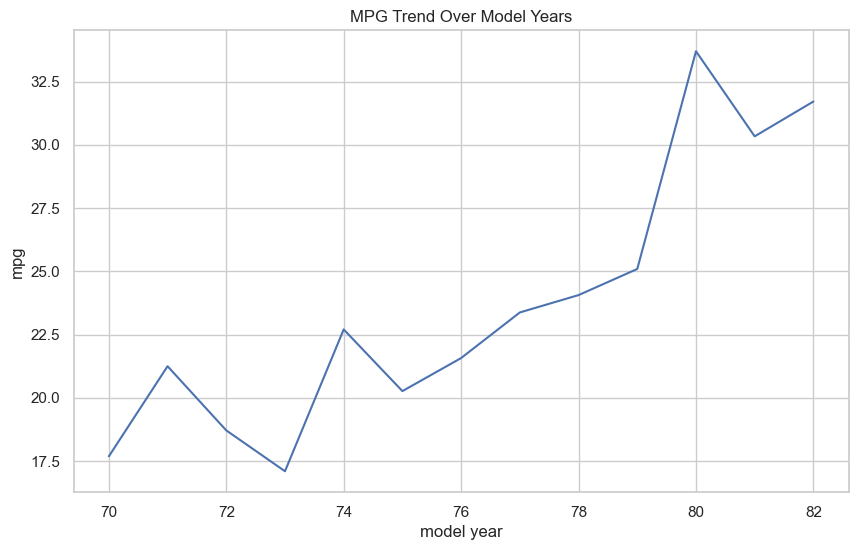

In [24]:
# MPG over model years
plt.figure(figsize=(10, 6))
sns.lineplot(x='model year', y='mpg', data=df, errorbar=None)
plt.title('MPG Trend Over Model Years')
plt.show()

In [25]:
# 9. Preprocessing for Modeling
print("\n=== Preprocessing for Modeling ===")
# Separate features and target
X = df.drop('mpg', axis=1)
y = df['mpg']


=== Preprocessing for Modeling ===


In [26]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [27]:
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (318, 8), Test shape: (80, 8)


In [28]:
# Identify numerical and categorical features
num_features = ['displacement', 'horsepower', 'weight', 'acceleration']
cat_features = ['cylinders', 'origin', 'manufacturer']

In [29]:
# Scale numerical features
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=cat_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_features, drop_first=True)

In [32]:
# Ensure both train and test have same columns after one-hot encoding
# Add missing columns to test set with 0 values
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

# Reorder columns to match train set
X_test = X_test[X_train.columns]

In [33]:
print("\nPreprocessed training data sample:")
print(X_train.head())
print("\nPreprocessed test data sample:")
print(X_test.head())


Preprocessed training data sample:
     displacement  horsepower    weight  acceleration  model year  \
3        1.090196    1.265821  0.552826     -1.319334          70   
18      -0.922996   -0.408635 -0.999667     -0.413182          70   
376     -0.981350   -0.948782 -1.124772      0.927922          82   
248     -0.981350   -1.164840 -1.392854      0.275493          78   
177     -0.747936   -0.219583 -0.327675     -0.231952          75   

     cylinders_4  cylinders_5  cylinders_6  cylinders_8  origin_Europe  ...  \
3          False        False        False         True          False  ...   
18          True        False        False        False          False  ...   
376         True        False        False        False          False  ...   
248         True        False        False        False          False  ...   
177         True        False        False        False           True  ...   

     manufacturer_plymouth  manufacturer_pontiac  manufacturer_renault  \


In [34]:
# Save processed data for modeling
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("\n=== Preprocessing Complete ===")


=== Preprocessing Complete ===


In [11]:
# Load preprocessed data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

In [12]:
# Initialize models with basic parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

In [13]:
# Hyperparameter grids for tuning
param_grids = {
    'Ridge Regression': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

In [15]:
# Dictionary to store results
results = {
    'Model': [],
    'Train R2': [],
    'Test R2': [],
    'Train MAE': [],
    'Test MAE': [],
    'Train RMSE': [],
    'Test RMSE': []
}

In [16]:
# Train and evaluate models
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    if name in param_grids:
        # Perform GridSearchCV for hyperparameter tuning
        gs = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
        print(f"Best params: {gs.best_params_}")
    else:
        # For Linear Regression (no hyperparameters)
        best_model = model
        best_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store results
    results['Model'].append(name)
    results['Train R2'].append(train_r2)
    results['Test R2'].append(test_r2)
    results['Train MAE'].append(train_mae)
    results['Test MAE'].append(test_mae)
    results['Train RMSE'].append(train_rmse)
    results['Test RMSE'].append(test_rmse)
    
    # Print metrics
    print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


=== Training Linear Regression ===
Train R2: 0.8698, Test R2: 0.8483
Train MAE: 2.1430, Test MAE: 2.2457
Train RMSE: 2.8570, Test RMSE: 2.8559

=== Training Ridge Regression ===
Best params: {'alpha': 10}
Train R2: 0.8495, Test R2: 0.8692
Train MAE: 2.2780, Test MAE: 2.1552
Train RMSE: 3.0723, Test RMSE: 2.6517

=== Training Lasso Regression ===
Best params: {'alpha': 0.01}
Train R2: 0.8619, Test R2: 0.8706
Train MAE: 2.2043, Test MAE: 2.1205
Train RMSE: 2.9428, Test RMSE: 2.6378

=== Training Random Forest ===
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Train R2: 0.9740, Test R2: 0.9112
Train MAE: 0.9018, Test MAE: 1.6305
Train RMSE: 1.2767, Test RMSE: 2.1855

=== Training Gradient Boosting ===
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Train R2: 0.9699, Test R2: 0.9032
Train MAE: 1.0552, Test MAE: 1.7956
Train RMSE: 1.3732, Test RMSE: 2.2817

=== Training XGBoost ===
Best params: {'learning_rate': 0.1, 'max_depth': 3, '

In [17]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [18]:
# Sort by Test R2 score (descending)
results_df = results_df.sort_values('Test R2', ascending=False)

# Display results
print("\n=== Model Performance Comparison ===")
print(results_df.to_string(index=False))


=== Model Performance Comparison ===
            Model  Train R2  Test R2  Train MAE  Test MAE  Train RMSE  Test RMSE
    Random Forest  0.974003 0.911165   0.901822  1.630535    1.276670   2.185484
Gradient Boosting  0.969921 0.903173   1.055241  1.795560    1.373248   2.281673
          XGBoost  0.963140 0.893612   1.142512  1.864628    1.520201   2.391673
              SVR  0.843749 0.880133   2.145173  2.016225    3.129909   2.538668
              KNN  0.877003 0.871775   1.992857  2.025536    2.776953   2.625678
 Lasso Regression  0.861876 0.870589   2.204279  2.120515    2.942759   2.637799
 Ridge Regression  0.849451 0.869221   2.278006  2.155173    3.072273   2.651706
Linear Regression  0.869812 0.848307   2.142994  2.245678    2.856977   2.855872


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5876\1624750312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test R2', y='Model', data=results_df, palette='viridis')


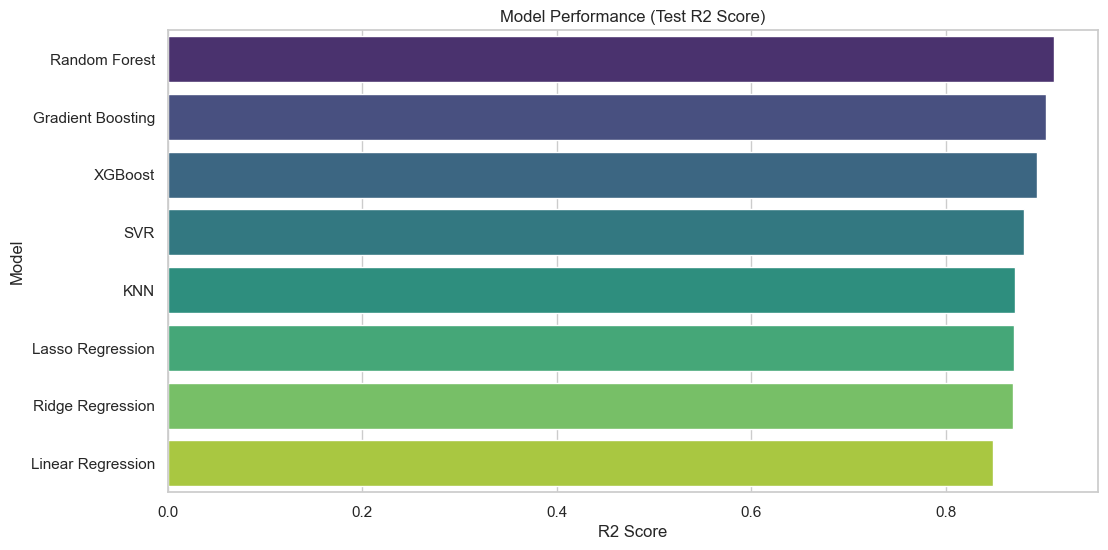

In [19]:
# Visualize model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='Test R2', y='Model', data=results_df, palette='viridis')
plt.title('Model Performance (Test R2 Score)')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.show()

In [20]:
# Select best model
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")


Best performing model: Random Forest


In [21]:
# Get predictions from best model
best_model = models[best_model_name]
if best_model_name in param_grids:
    gs = GridSearchCV(models[best_model_name], param_grids[best_model_name], cv=5, 
                     scoring='neg_mean_squared_error', n_jobs=-1)
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_

In [22]:
# Final predictions on test set
final_predictions = best_model.predict(X_test)

In [23]:
# Create DataFrame with actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual MPG': y_test,
    'Predicted MPG': final_predictions,
    'Absolute Error': np.abs(y_test - final_predictions)
})

In [24]:
# Display sample predictions
print("\n=== Sample Predictions from Best Model ===")
print(comparison_df.head(10).to_string(index=False))


=== Sample Predictions from Best Model ===
 Actual MPG  Predicted MPG  Absolute Error
       33.0      30.962303        2.037697
       28.0      28.969298        0.969298
       19.0      19.625500        0.625500
       13.0      14.864463        1.864463
       14.0      14.215280        0.215280
       27.0      25.993161        1.006839
       24.0      25.550517        1.550517
       13.0      12.026163        0.973837
       17.0      19.747236        2.747236
       21.0      19.172619        1.827381


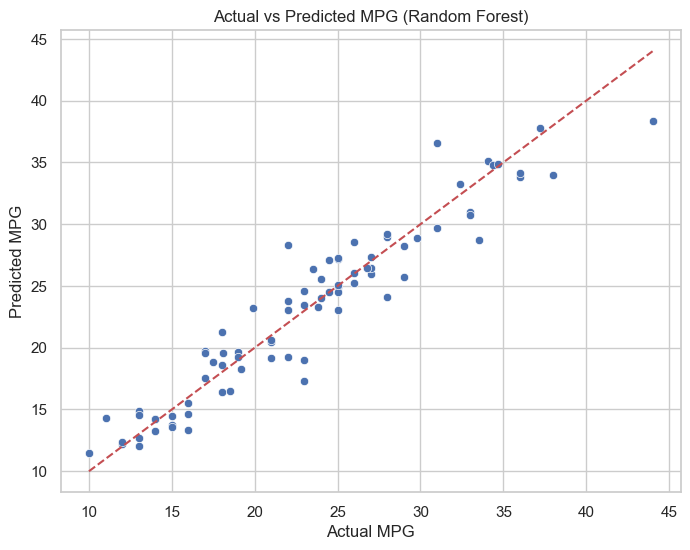

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual MPG', y='Predicted MPG', data=comparison_df)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'Actual vs Predicted MPG ({best_model_name})')
plt.show()

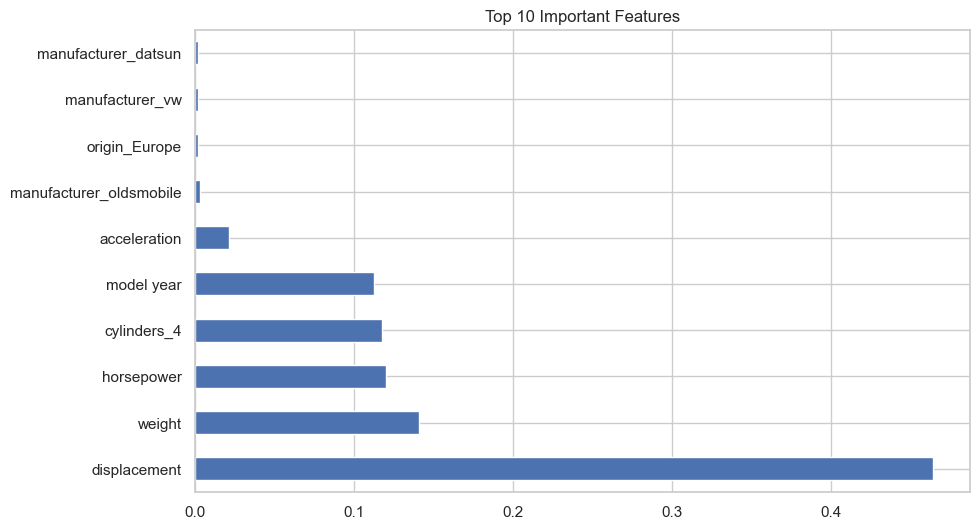

In [26]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    feature_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importance.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Important Features')
    plt.show()
elif hasattr(best_model, 'coef_'):
    plt.figure(figsize=(10, 6))
    coef = pd.Series(best_model.coef_, index=X_train.columns)
    coef.sort_values().plot(kind='barh')
    plt.title('Model Coefficients')
    plt.show()

In [28]:
# Save the best model separately for easy access
best_model_save_path = 'best_model.pkl'
with open(best_model_save_path, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f"\nSaved best model ({best_model_name}) to {best_model_save_path}")
print("Model training and evaluation complete!")


Saved best model (Random Forest) to best_model.pkl
Model training and evaluation complete!
